In [137]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from sklearn.preprocessing import StandardScaler
import missingno as msno

# Importing Dataset 

In [138]:
df  = pd.read_csv("data/kaggle_1.csv")
df.sample(20)

,Unnamed: 0.1,Unnamed: 0,text,category,date,title,author
4175,4175,4175.0,<BOS> The touch of the wing is in its tip. The...,Boys -- Juvenile fiction; England -- Juvenile ...,1891.0,Bevis: The Story of a Boy,JefferiesRichard
482,482,482.0,\n\nThere is not much to recommend the Liquor ...,news,1890.0,672350.txt,\n\nThere is not much to recommend the Liquo
8961,8961,8961.0,NaN,NaN,NaN,NaN,NaN
4161,4161,4161.0,<BOS> He could not help thinking that if he ha...,Inheritance and succession -- Fiction; England...,1877.0,World's End: A Story in Three Books,JefferiesRichard
8159,8159,8159.0,NaN,NaN,NaN,NaN,NaN
5429,5429,5429.0,\n\nA huge telescope under construction in a r...,mag,2000.0,408850.txt,\n\nA huge telescope under construction in a
1831,1831,1831.0,<BOS> No mothers love had taught her wisdom. S...,Fiction,1883.0,Marion Arleigh's Penance\nEveryday Life Librar...,BrameCharlotteM
8684,8684,8684.0,NaN,NaN,NaN,NaN,NaN
3401,3401,3401.0,<BOS> and he got the fragments of his gun toge...,Children's stories; Children -- Conduct of lif...,1877.0,A Great Emergency and Other Tales,EwingJulianaHoratia
771,771,771.0,"<BOS> By Alla, I like it not. Art thou a cowar...","Tipu Sultan, Fath 'Ali, Nawab of Mysore, 1753-...",1880.0,Tippoo Sultaun: A tale of the Mysore war,TaylorMeadows


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9729 entries, 0 to 9728
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  9729 non-null   int64  
 1   Unnamed: 0    9396 non-null   float64
 2   text          8295 non-null   object 
 3   category      8295 non-null   object 
 4   date          8295 non-null   object 
 5   title         8295 non-null   object 
 6   author        8281 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 532.2+ KB


# Checking for missing values

<Axes: >

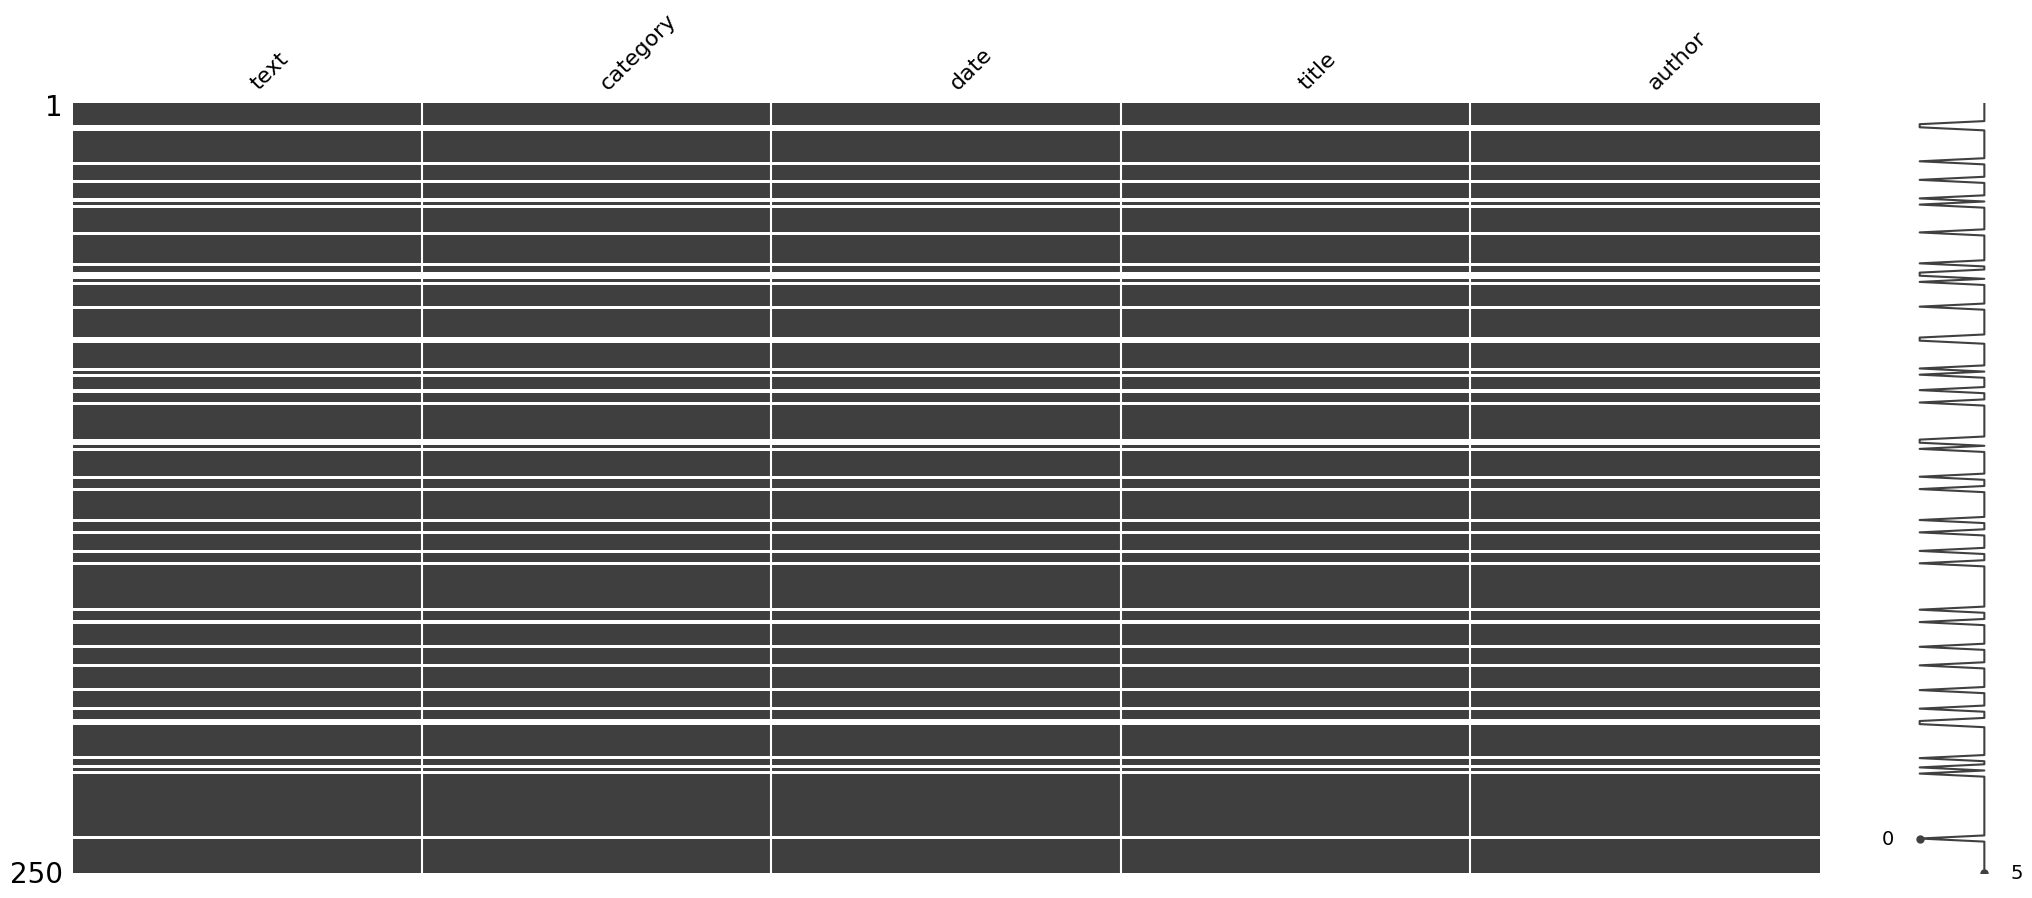

In [140]:
df.drop(["Unnamed: 0.1","Unnamed: 0"],axis=1,inplace=True)
msno.matrix(df.sample(250))

In [141]:
df.dropna(inplace=True)

# Removing all non-alphanumeric characters followed by other errors in the text

In [142]:
df['text'] = df['text'].replace('ſ', 's', regex=True)
df['text'] = df['text'].replace('<BOS>', ' ', regex=True)
df['text'] = df['text'].replace("[^a-zA-Z0-9 ']", ' ', regex=True)
df['text'] = df['text'].replace("@", ' ', regex=True)
df['text'] = df['text'].replace("EOS", ' ', regex=True)
df['text'] = df['text'].replace("haue", ' ', regex=True)
df['text'] = df['text'].replace("vnto", ' ', regex=True)

# Splitting the years into decades and restricting them to the range from 1500 to 1920

In [143]:
df['date'] = pd.to_numeric(df['date'], errors='coerce', downcast='integer')
df['decade'] = (df['date'] // 10) * 10

In [144]:
df = df[(df["decade"] >= 1500) & (df["decade"] < 1920)]


In [145]:
# Splitting the text into multiple sections for books that have a lot of data

def split_rows_based_on_word_count(df, column_name, word_count_threshold):
    new_rows = []

    for index, row in df.iterrows():
        text = row[column_name]
        words = text.split()
        
        if len(words) > word_count_threshold:
            # Split the text into multiple rows
            split_texts = [words[i:i+word_count_threshold] for i in range(0, len(words), word_count_threshold)]
            
            for split_text in split_texts:
                new_row = row.copy()
                new_row[column_name] = ' '.join(split_text)
                new_rows.append(new_row)
        else:
            # Keep the row as it is
            new_rows.append(row)

    return pd.DataFrame(new_rows, columns=df.columns)


word_count_threshold = 750  # Set your desired word count threshold
df = split_rows_based_on_word_count(df, 'text', word_count_threshold)

# Now, 'new_dataframe' contains the rows split based on the word count threshold


In [146]:
threshold = 800
df = df.groupby('decade').head(threshold)
print(df)


                                                   text  \
0     TabulaChronicles of England 1502Approx 1361 KB...   
0     text with mnemonic sdata character entities di...   
0     Brytayneleafc v viIoathan kynge of IewesAmaria...   
0     quevult saluus esseMercus popeIulius popeConst...   
0     the fourth popeInnocencius the fourth popeleaf...   
...                                                 ...   
9646  appealed to me the kind of nature romance whic...   
9646  long delayed Yet she lingered with us six week...   
9646  exemplified in the very lively interest which ...   
9646  not what awakened in my soul The two retreats ...   
9646  into dire distress before very long we learned...   

                   category    date           title         author  decade  
0               unknown.xml  1502.0          tabula  ranulf-higden  1500.0  
0               unknown.xml  1502.0          tabula  ranulf-higden  1500.0  
0               unknown.xml  1502.0          tabula  ranulf-

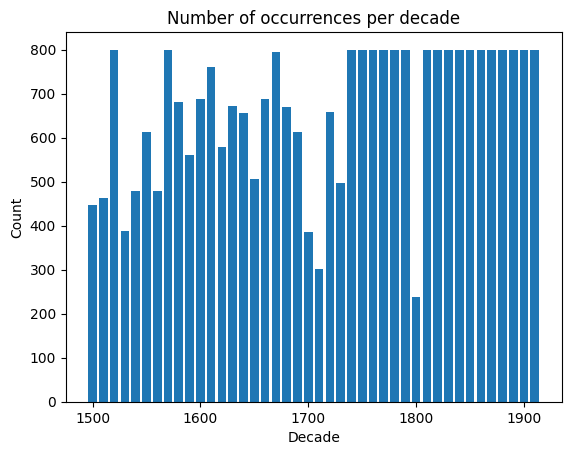

In [147]:
# Visualizing according to number of rows per decade to better understand the data distribution
decade_counts = df['decade'].value_counts().sort_index()

# Create a bar graph
plt.bar(decade_counts.index, decade_counts.values, width=8)  # Adjust the width as needed

# Set labels and title
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Number of occurrences per decade')

# Display the graph
plt.show()


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28012 entries, 0 to 9646
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      28012 non-null  object 
 1   category  28012 non-null  object 
 2   date      28012 non-null  float64
 3   title     28012 non-null  object 
 4   author    28012 non-null  object 
 5   decade    28012 non-null  float64
dtypes: float64(2), object(4)
memory usage: 1.5+ MB


# SVR - TfIdf 

Training RMSE: 51.648465156923756
Testing RMSE: 51.86080790194328
Training MAE: 39.31726924789625
Testing MAE: 39.856056615685894
Training R-squared: 0.818705897087546
Testing R-squared: 0.8142737887010444


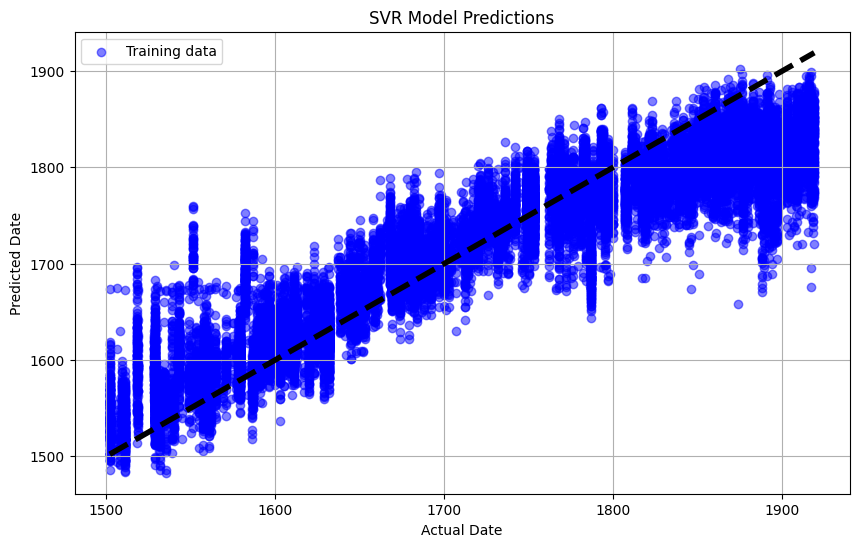

In [149]:

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=4000)
train_text_features = tfidf_vectorizer.fit_transform(train_data)
test_text_features = tfidf_vectorizer.transform(test_data)

# Initialize and train the SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(train_text_features, train_labels)

# Predictions
train_predictions = svr_model.predict(train_text_features)
test_predictions = svr_model.predict(test_text_features)

# Calculate RMSE, MAE, and R2 Score
train_rmse = sqrt(mean_squared_error(train_labels, train_predictions))
test_rmse = sqrt(mean_squared_error(test_labels, test_predictions))
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

# Feature Importance Plot - Not applicable for SVR

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, train_predictions, color='blue', label='Training data', alpha=0.5)
#plt.scatter(test_labels, test_predictions, color='red', label='Testing data', alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('SVR Model Predictions')
plt.xlabel('Actual Date')
plt.ylabel('Predicted Date')
plt.grid(True)
plt.legend()
plt.show()


# SVR - Word2Vec

In [164]:


# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to Word2Vec features
# Assuming 'text' column contains lists of tokenized words
word2vec_model = Word2Vec(sentences=train_data, vector_size=400, window=7, min_count=1, workers=24)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=15)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

# Function to average word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Function to generate word vectors for each sentence
def wordvec_features(X, model, vocabulary, num_features):
    features = [average_word_vectors(words, model, vocabulary, num_features)
                for words in X  if words]
    return np.array(features)

# Transform text data to Word2Vec features
train_text_features = wordvec_features(train_data, word_vectors, max_words, 400)
test_text_features = wordvec_features(test_data, word_vectors, max_words, 400)

# Initialize and train the SVR model
svr_model = SVR(kernel='poly')
svr_model.fit(train_text_features, train_labels)

# Predictions
train_predictions = svr_model.predict(train_text_features)
test_predictions = svr_model.predict(test_text_features)

# Calculate RMSE, MAE, and R2 Score
train_rmse_w2v = sqrt(mean_squared_error(train_labels, train_predictions))
test_rmse_w2v = sqrt(mean_squared_error(test_labels, test_predictions))
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)



In [168]:
print("Training RMSE:", train_rmse_w2v)
print("Testing RMSE:", train_rmse_w2v)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)


Training RMSE: 108.49489998504161
Testing RMSE: 108.49489998504161
Training MAE: 84.31679067984105
Testing MAE: 83.58416021923006
Training R-squared: 0.2000046085111865
Testing R-squared: 0.32226360922606245


# Gradient Boosting - TfIdf / Word2Vec

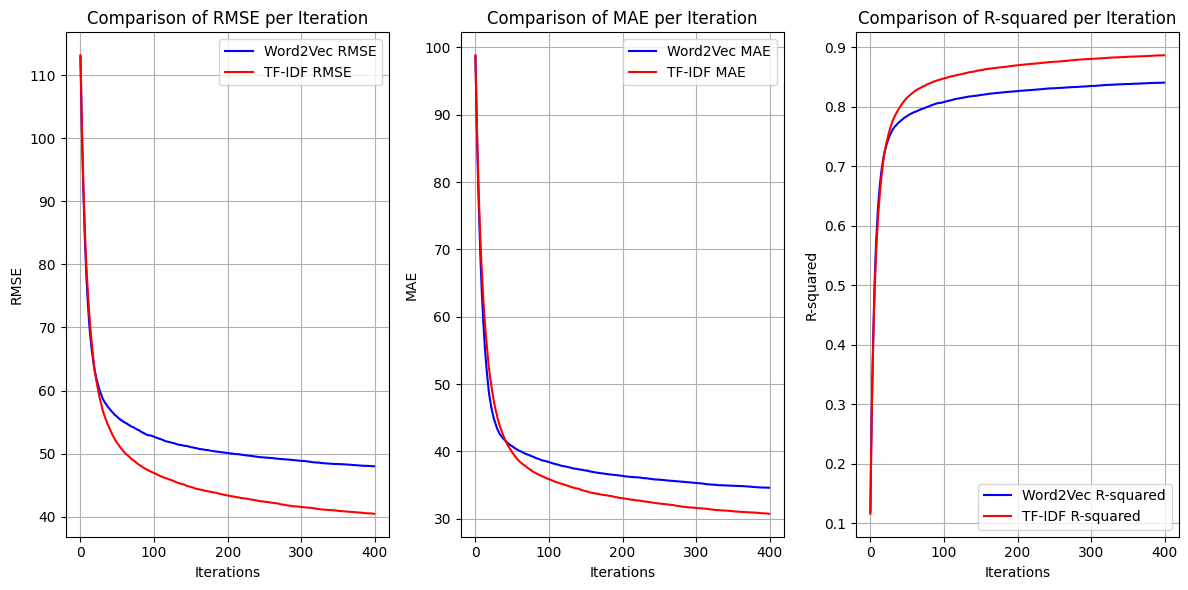

In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# Assuming df is your DataFrame

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer    = TfidfVectorizer(max_features=400)
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Convert text data to Word2Vec features
word2vec_model = Word2Vec(sentences=train_data, vector_size=400, window=5, min_count=1, workers=16)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

train_text_features_wv = wordvec_features(train_data, word_vectors, max_words, 400)
test_text_features_wv = wordvec_features(test_data, word_vectors, max_words, 400)

# Initialize and train the Gradient Boosting model for TF-IDF
gb_model_tfidf = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=42)
gb_model_tfidf.fit(train_text_features_tfidf, train_labels)

# Initialize and train the Gradient Boosting model for Word2Vec
gb_model_wv = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=42)
gb_model_wv.fit(train_text_features_wv, train_labels)

# Track RMSE, MAE, and R-squared over iterations for test data for TF-IDF
test_rmse_scores_tfidf = []
test_mae_scores_tfidf = []
test_r2_scores_tfidf = []
for i, y_pred in enumerate(gb_model_tfidf.staged_predict(test_text_features_tfidf)):
    test_rmse_scores_tfidf.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_tfidf.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_tfidf.append(r2_score(test_labels, y_pred))

# Track RMSE, MAE, and R-squared over iterations for test data for Word2Vec
test_rmse_scores_wv = []
test_mae_scores_wv = []
test_r2_scores_wv = []
for i, y_pred in enumerate(gb_model_wv.staged_predict(test_text_features_wv)):
    test_rmse_scores_wv.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_wv.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_wv.append(r2_score(test_labels, y_pred))

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(test_rmse_scores_wv, label='Word2Vec RMSE', color='blue')
plt.plot(test_rmse_scores_tfidf, label='TF-IDF RMSE', color='red')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_mae_scores_wv, label='Word2Vec MAE', color='blue')
plt.plot(test_mae_scores_tfidf, label='TF-IDF MAE', color='red')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(test_r2_scores_wv, label='Word2Vec R-squared', color='blue')
plt.plot(test_r2_scores_tfidf, label='TF-IDF R-squared', color='red')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


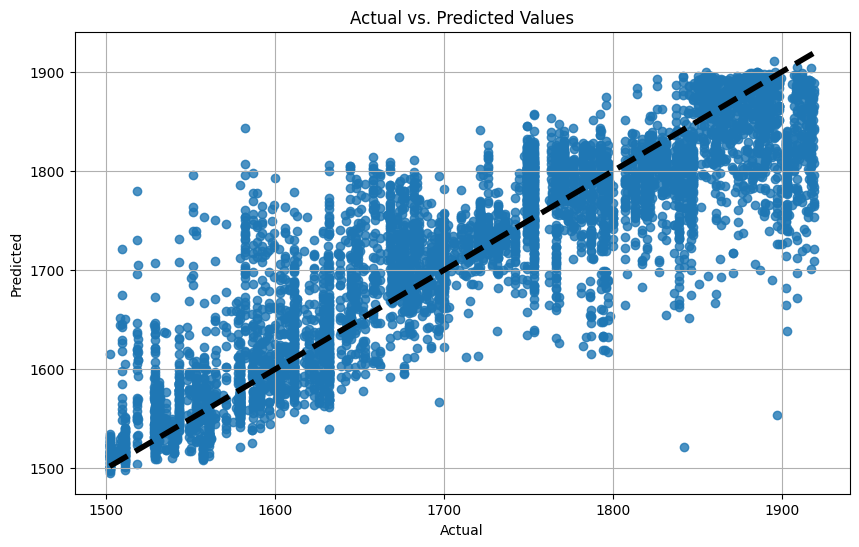

In [156]:

# Convert text data to Word2Vec features
word2vec_model = Word2Vec(sentences=train_data, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

# Function to average word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Function to generate word vectors for each sentence
def wordvec_features(X, model, vocabulary, num_features):
    features = [average_word_vectors(words, model, vocabulary, num_features)
                for words in X if words]
    return np.array(features)

# Transform text data to Word2Vec features
train_text_features = wordvec_features(train_data, word_vectors, max_words, 100)
test_text_features = wordvec_features(test_data, word_vectors, max_words, 100)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(train_text_features, train_labels)

# Track RMSE loss over iterations for test data
test_score = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(test_text_features)):
    test_score[i] = sqrt(mean_squared_error(test_labels, y_pred))

# Track RMSE loss over iterations for training data
train_score = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(train_text_features)):
    train_score[i] = sqrt(mean_squared_error(train_labels, y_pred))

# Generate predictions
predictions = gb_model.predict(test_text_features)

# Plotting Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.8)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()


# Xgboost Tfidf and Word2vec

C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:89.58559	validation_0-mae:77.00547
[1]	validation_0-rmse:68.85312	validation_0-mae:57.99930
[2]	validation_0-rmse:54.80084	validation_0-mae:45.23880
[3]	validation_0-rmse:45.86906	validation_0-mae:36.68843
[4]	validation_0-rmse:40.28151	validation_0-mae:30.96793
[5]	validation_0-rmse:36.69507	validation_0-mae:27.28269
[6]	validation_0-rmse:34.45175	validation_0-mae:24.90681
[7]	validation_0-rmse:33.18021	validation_0-mae:23.47103
[8]	validation_0-rmse:32.31946	validation_0-mae:22.54874
[9]	validation_0-rmse:31.62278	validation_0-mae:21.88555
[10]	validation_0-rmse:31.03958	validation_0-mae:21.42797
[11]	validation_0-rmse:30.58488	validation_0-mae:21.03404
[12]	validation_0-rmse:30.28222	validation_0-mae:20.76020
[13]	validation_0-rmse:30.01003	validation_0-mae:20.55516
[14]	validation_0-rmse:29.76149	validation_0-mae:20.35122
[15]	validation_0-rmse:29.61077	validation_0-mae:20.22823
[16]	validation_0-rmse:29.42795	validation_0-mae:20.08845
[17]	validation_0-rmse:2

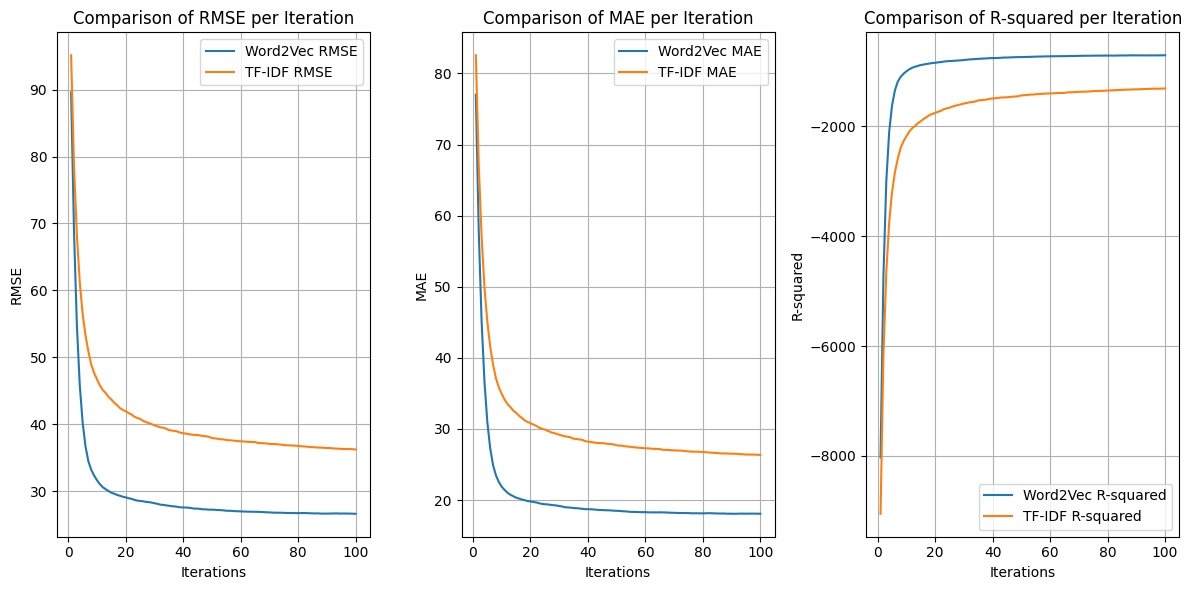

In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Tokenize the text data for Word2Vec
tokenized_data = [text.split() for text in train_data]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=400, window=9, min_count=1, workers=12)

# Convert text data to Word2Vec embeddings
def get_text_embedding(text, model):
    embedding = [model.wv[word] for word in text.split() if word in model.wv]
    if embedding:
        return sum(embedding) / len(embedding)
    else:
        return np.zeros(400)  # Adjusted to match vector_size

train_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in train_data])
test_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in test_data])

# Train and evaluate XGBoost with Word2Vec
xgb_model_wv = XGBRegressor()
eval_set_wv = [(test_text_features_wv, test_labels)]
xgb_model_wv.fit(train_text_features_wv, train_labels, eval_metric=["rmse", "mae", "rmse", "mae"], eval_set=eval_set_wv, verbose=True)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Train and evaluate XGBoost with TF-IDF
xgb_model_tfidf = XGBRegressor()
eval_set_tfidf = [(test_text_features_tfidf, test_labels)]
xgb_model_tfidf.fit(train_text_features_tfidf, train_labels, eval_metric=["rmse", "mae", "rmse", "mae"], eval_set=eval_set_tfidf, verbose=True)

# Get evaluation results for Word2Vec
results_wv = xgb_model_wv.evals_result()
rmse_wv = results_wv['validation_0']['rmse']
mae_wv = results_wv['validation_0']['mae']
r_squared_wv = [1 - (rmse ** 2) for rmse in rmse_wv]
epochs_wv = range(1, len(rmse_wv) + 1)

# Get evaluation results for TF-IDF
results_tfidf = xgb_model_tfidf.evals_result()
rmse_tfidf = results_tfidf['validation_0']['rmse']
mae_tfidf = results_tfidf['validation_0']['mae']
r_squared_tfidf = [1 - (rmse ** 2) for rmse in rmse_tfidf]
epochs_tfidf = range(1, len(rmse_tfidf) + 1)

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_wv, rmse_wv, label='Word2Vec RMSE')
plt.plot(epochs_tfidf, rmse_tfidf, label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_wv, mae_wv, label='Word2Vec MAE')
plt.plot(epochs_tfidf, mae_tfidf, label='TF-IDF MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_wv, r_squared_wv, label='Word2Vec R-squared')
plt.plot(epochs_tfidf, r_squared_tfidf, label='TF-IDF R-squared')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
predictions_wv = xgb_model_wv.predict(test_text_features_wv)

# Making predictions with the TF-IDF model
predictions_tfidf = xgb_model_tfidf.predict(test_text_features_tfidf.toarray()) 

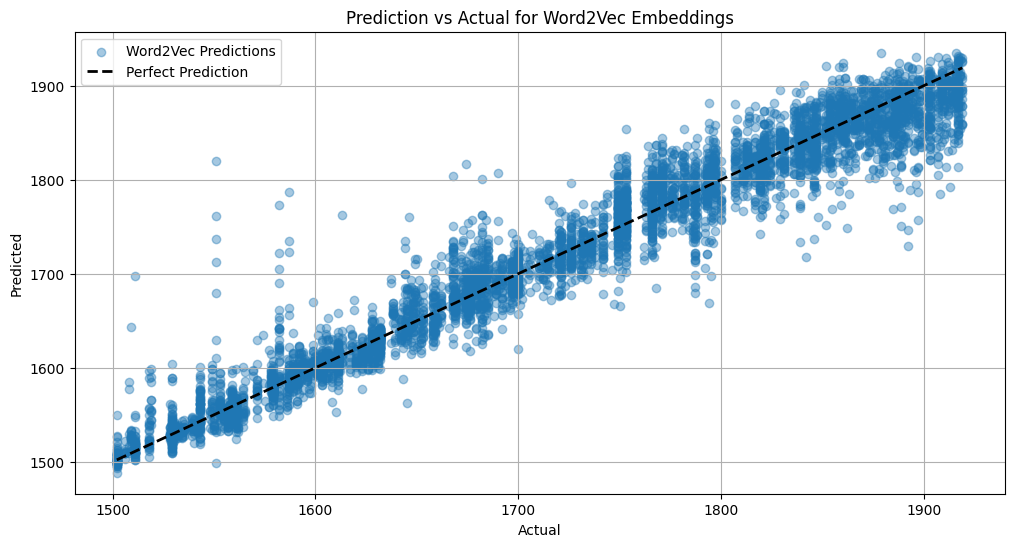

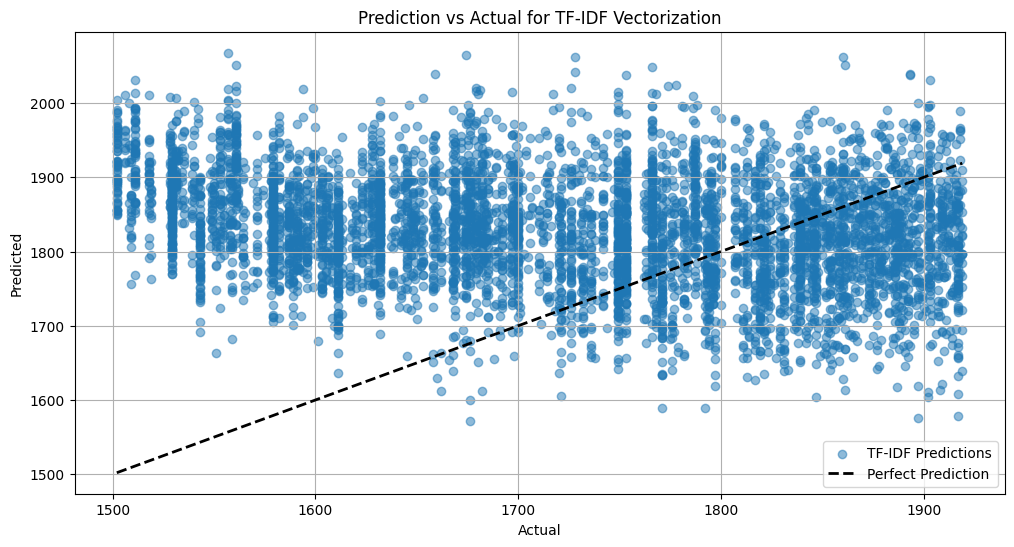

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(test_labels, predictions_wv, alpha=0.4, label='Word2Vec Predictions')
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual for Word2Vec Embeddings')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Prediction vs Actual for TF-IDF
plt.figure(figsize=(12, 6))
plt.scatter(test_labels, predictions_tfidf, alpha=0.5, label='TF-IDF Predictions')
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual for TF-IDF Vectorization')
plt.legend()
plt.grid(True)
plt.show()

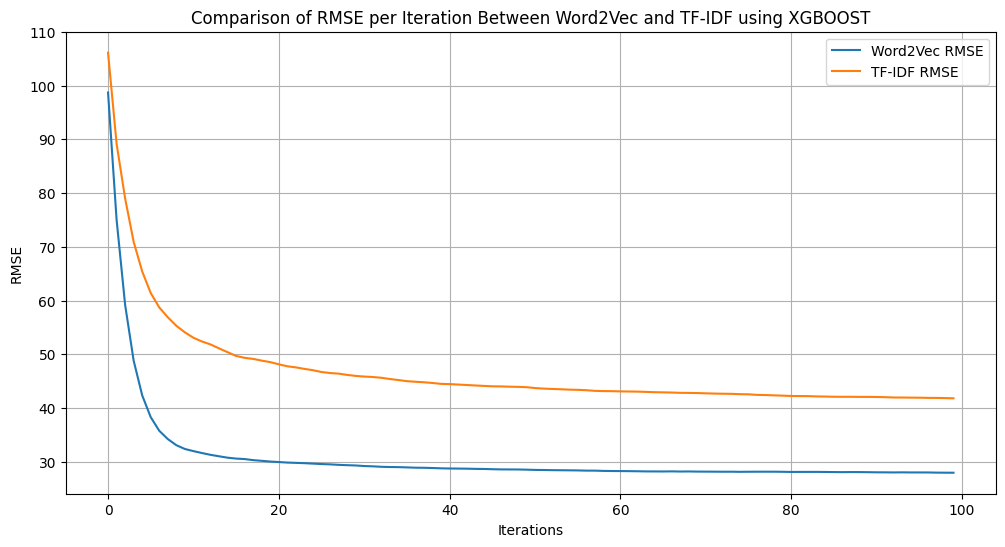

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Assuming x_axis_wv, results_wv['validation_0']['rmse'], x_axis_tfidf, results_tfidf['validation_0']['rmse'] are defined
plt.figure(figsize=(12, 6))
plt.plot(x_axis_wv, results_wv['validation_0']['rmse'], label='Word2Vec RMSE')
plt.plot(x_axis_tfidf, results_tfidf['validation_0']['rmse'], label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration Between Word2Vec and TF-IDF using XGBOOST')
plt.legend()
plt.grid(True)

# To display the chart on screen
plt.show()

# To save the figure with a transparent background
plt.savefig('comparison_chart_transparent.png', transparent=True)


# SHAP FOR NON_BERT MODELS

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
import shap

# Splitting data
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer_gb = TfidfVectorizer(max_features=3002)
train_text_features_gb = tfidf_vectorizer_gb.fit_transform(train_data).toarray()
test_text_features_gb = tfidf_vectorizer_gb.transform(test_data).toarray()

# Train the GradientBoostingRegressor
gb_model = GradientBoostingRegressor()
gb_model.fit(train_text_features_gb, train_labels)

# Make predictions on the test set
predictions = gb_model.predict(test_text_features_gb)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_labels, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# SHAP explanation
feature_names_gb = tfidf_vectorizer_gb.get_feature_names_out()
explainer_gb = shap.Explainer(gb_model.predict, train_text_features_gb[:50], feature_names=feature_names_gb)
shap_values_gb = explainer_gb(test_text_features_gb[:50], max_evals=4900)

# Visualize SHAP values with waterfall plot
shap.initjs()
shap.plots.waterfall(shap_values_gb[7])


PermutationExplainer explainer: 51it [06:30,  7.81s/it]                        


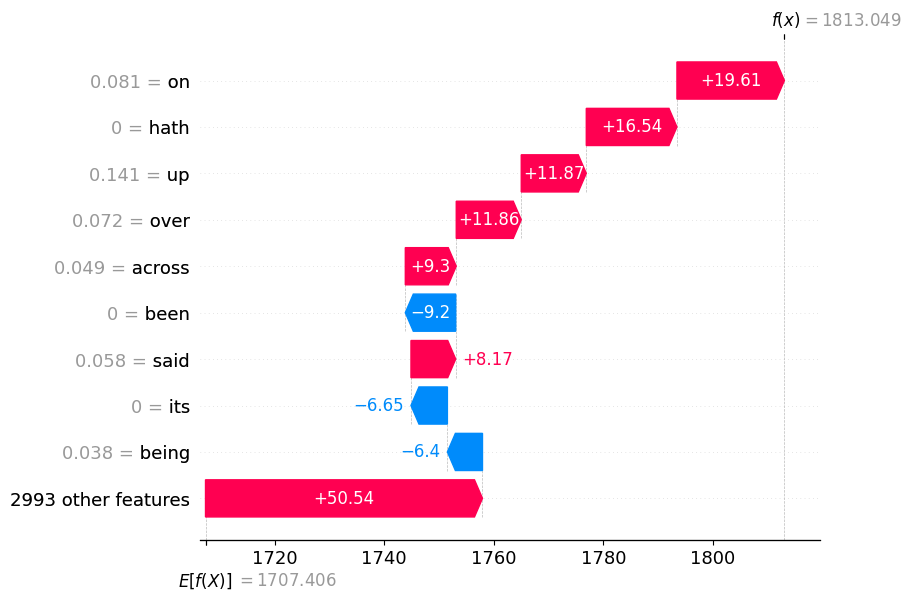

In [29]:
shap_values_gb = explainer_gb(test_text_features_gb[:50], max_evals=4900)

# Visualize SHAP values with waterfall plot
shap.initjs()
shap.plots.waterfall(shap_values_gb[7])


C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E

Root Mean Squared Error (RMSE): 53.717277000265874


PermutationExplainer explainer: 11it [00:30,  3.84s/it]                        

(10, 3002)


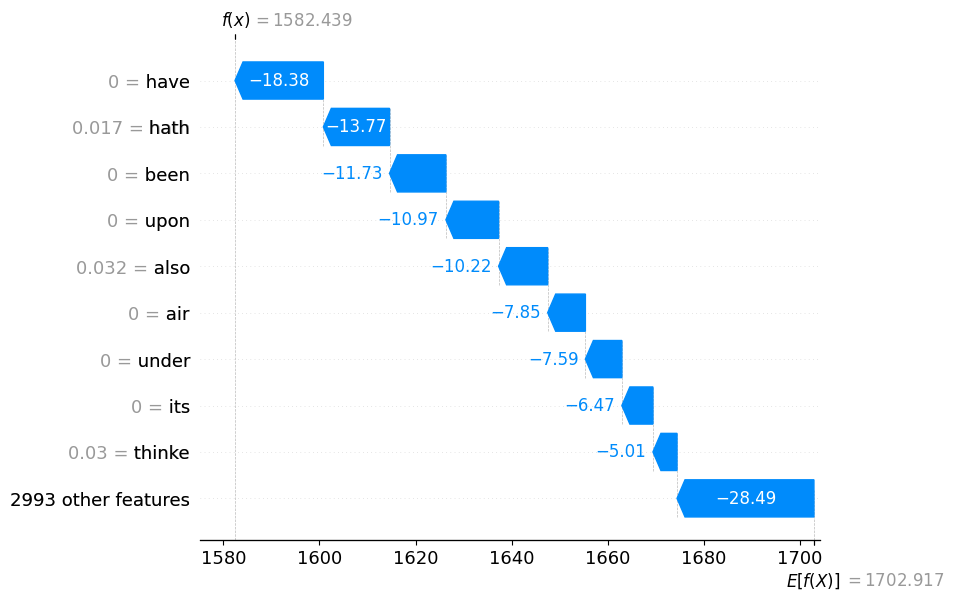

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer_xgb = TfidfVectorizer(max_features=3002)

# Convert to cupy arrays for GPU computation
train_text_features_xgb = tfidf_vectorizer_xgb.fit_transform(train_data).toarray()
test_text_features_xgb = tfidf_vectorizer_xgb.transform(test_data).toarray()

# Train the XGBoost model on GPU
#xgb_model = RandomForestRegressor()
xgb_model = XGBRegressor(tree_method='gpu_hist')  # Set tree_method='gpu_hist' for GPU training
xgb_model.fit(train_text_features_xgb, train_labels)

# Make predictions on the test set
predictions_xgb = xgb_model.predict(train_text_features_xgb)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_labels, predictions_xgb))
print(f"Root Mean Squared Error (RMSE): {rmse}")

import shap

feature_names_xgb = tfidf_vectorizer_xgb.get_feature_names_out()
explainer = shap.Explainer(xgb_model.predict,train_text_features[:50],   feature_names=feature_names_xgb)
shap_values_xgb = explainer(test_text_features[:50], max_evals=4000)
print(shap_values_xgb.values.shape) # (5000, 16438, 2)

shap.initjs()

shap.plots.waterfall(shap_values_xgb[7])


Root Mean Squared Error (RMSE): 109.58701706142669


PermutationExplainer explainer: 11it [11:42, 70.28s/it]                        


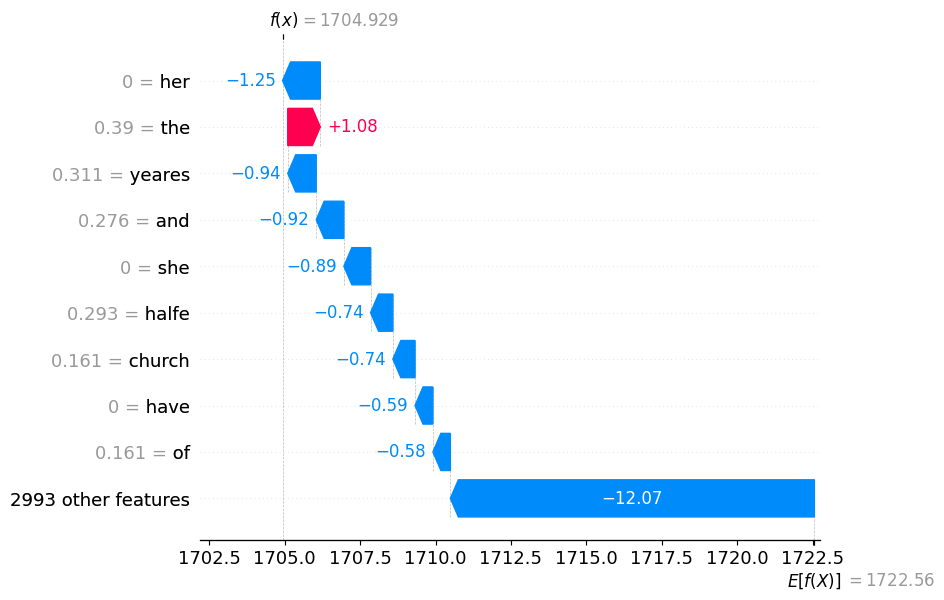

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.svm import SVR
import shap

# Splitting data
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=3002)
train_text_features = tfidf_vectorizer.fit_transform(train_data).toarray()
test_text_features = tfidf_vectorizer.transform(test_data).toarray()

# Train the SVR model
svr_model = SVR()
svr_model.fit(train_text_features, train_labels)

# Make predictions on the test set
predictions = svr_model.predict(test_text_features)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_labels, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# SHAP explanation
feature_names = tfidf_vectorizer.get_feature_names_out()
explainer = shap.Explainer(svr_model.predict, train_text_features[:50], feature_names=feature_names)
shap_values = explainer(test_text_features[:50], max_evals=4000)

# Visualize SHAP values with waterfall plot
shap.initjs()
shap.plots.waterfall(shap_values[7])


In [85]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['text'], df['date'], test_size=0.2, random_state=42)

# Train Word2Vec model on the text data
word2vec_model = Word2Vec(sentences=train_data, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)

# Function to average word vectors for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

# Convert text data to Word2Vec features
train_text_features = [average_word_vectors(sentence, word2vec_model, word2vec_model.wv.index_to_key, 100) for sentence in train_data]
test_text_features = [average_word_vectors(sentence, word2vec_model, word2vec_model.wv.index_to_key, 100) for sentence in test_data]

# Convert lists to numpy arrays
train_text_features = np.array(train_text_features)
test_text_features = np.array(test_text_features)

# Train the XGBoost model on GPU
xgb_model = XGBRegressor(tree_method='gpu_hist')  # Set tree_method='gpu_hist' for GPU training
xgb_model.fit(train_text_features, train_labels)

# Make predictions on the test set
predictions = xgb_model.predict(test_text_features)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_labels, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (RMSE): 65.2241720927936


C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


# DistilBERT 

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Sample DataFrame (replace this with your actual data)

# Assuming df is defined

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Scale labels
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.values.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.values.reshape(-1, 1)).flatten()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"  # You can use any other transformer model available in the Hugging Face model hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Regression with one output label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Tokenize the text data
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data.tolist(), truncation=True, padding=True)

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels_scaled, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels_scaled, dtype=torch.float32).to(device)

# Convert data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                                               torch.tensor(train_encodings['attention_mask']).to(device),
                                               train_labels_tensor)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                              torch.tensor(test_encodings['attention_mask']).to(device),
                                              test_labels_tensor)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training
model.train()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=38, shuffle=True)

for epoch in range(7):  # Adjust the number of epochs as needed
    print('epoch')
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
        loss = outputs.loss
        loss.backward()
        optimizer.step()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch
epoch
epoch
epoch
epoch
epoch
epoch


In [57]:
# Evaluation
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=38, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze(1)
        predictions.extend(preds.tolist())

# Scale predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

rmse_distilbert = sqrt(mean_squared_error(test_labels, predictions))



In [58]:
print(f"Root Mean Squared Error (RMSE): {rmse_distilbert}")

Root Mean Squared Error (RMSE): 17.938860266300093


In [59]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R-squared (R2)
r_squared = r2_score(test_labels, predictions)
print(f"R-squared (R2): {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

R-squared (R2): 0.9777779389015259
Mean Absolute Error (MAE): 12.25092137770448


# DistBERT SHAP

In [60]:


import datasets
import numpy as np
import scipy as sp
import torch
import transformers
import shap 
# load a BERT sentiment analysis model



# define a prediction function
def f(x):
    
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=500, truncation=True)
            for v in x
        ]
    ).cuda()
    
    outputs = model(tv)[0].detach().cpu().numpy()
    outputs = scaler.inverse_transform(np.array(outputs).reshape(-1, 1)).flatten()
    #print(outputs)
    #preds = outputs.logits.squeeze(1)
    #scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    #val = sp.special.logit(scores[1:])  # use one vs rest logit units
    return outputs

explainer = shap.Explainer(f, tokenizer)


In [93]:
shap_text = list(test_data.values)[:60]

In [94]:
shap_text[2]

"3 1640 with a Short and Necessary View of some precedent Years written by Thomas May Esq Secretary to the Parliament and published by their authority In 1650 he published in 8vo A Breviary of the History of the Parliament of England Besides these works Mr Philips tells us he wrote a History of Henry IV in English verse the Comedy of the Old Wives Tale and the History of Orlando Furioso but the latter Mr Langbaine who is a higher authority than Philips assures us was written before May was able to hold a pen much less to write a play being printed in 4to London 1594 Mr Winstanley says that in his history he shews all the spleen of a mal content and had he been preferred to the Bays as he happened to be disappointed he would have embraced the Royal interest with as much zeal as he did the republican for a man who espouses a cause from spite only can be depended upon by no party because he acts not upon any principles of honour or conviction Our author died suddenly in the year 1652 and 

In [ ]:
token_val = [str(i) for i in test_data.values]
# Explain the predictions
shap_values = explainer(shap_text[20:50], fixed_context=1)

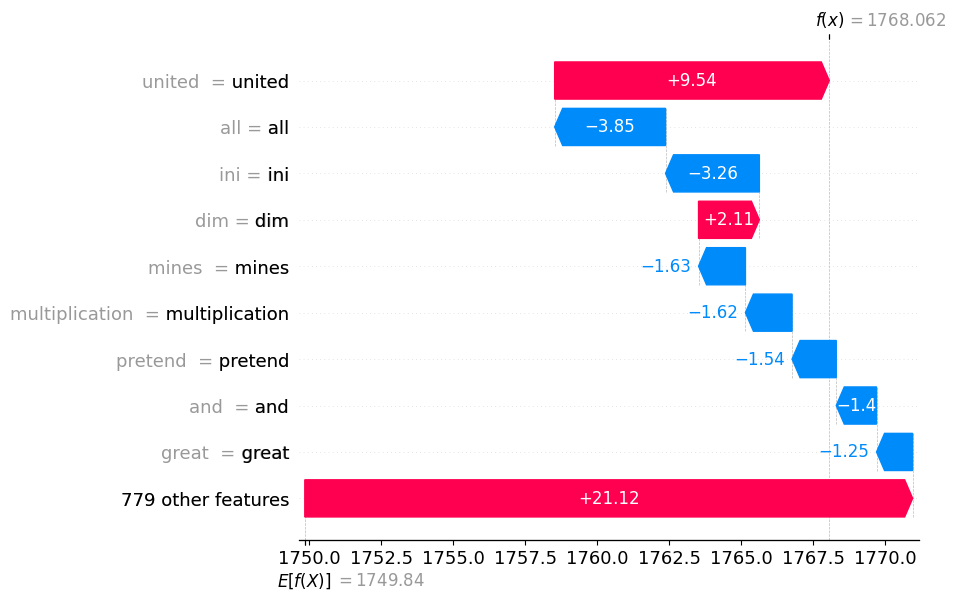

In [136]:
shap.plots.waterfall(shap_values[1])